In [1]:
!nvidia-smi

Thu Mar 21 23:06:31 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   32C    P0    36W / 150W |  32472MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import gc
import os

def clear_gpu_memory(*args):
    """
    Clears specified PyTorch tensors or models from GPU memory, then clears the GPU memory cache.
    
    Args:
    *args: Variable length argument list. Expected to be PyTorch tensors or models.
    """
    # Attempt to delete each passed argument
    for arg in args:
        # Check if the argument is a tensor and is on GPU
        if isinstance(arg, torch.Tensor) and arg.is_cuda:
            # Delete the argument to release its GPU memory
            del arg
        # If it's a model or other structure with parameters
        elif hasattr(arg, 'parameters'):
            # Delete each parameter to release its GPU memory
            for param in arg.parameters():
                if param.is_cuda:
                    del param
    
    # Explicitly collect garbage
    gc.collect()
    
    # Empty the CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cache has been emptied.")


In [3]:
#import transformer_lens

import sys
from fancy_einsum import einsum

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformers import AutoTokenizer, pipeline, logging, AutoModelForCausalLM
from transformer_lens import ActivationCache, HookedTransformer

from huggingface_hub import notebook_login
from datasets import Dataset
#imdb = load_dataset("parquet", data_files={'train': 'imdb/plain_text/train-00000-of-00001.parquet', 'test': 'imdb/plain_text/train-00000-of-00001.parquet'})
import pandas as pd
import transformers
import torch
import einops  # Make sure einops is imported

from neel_plotly import line, imshow, scatter
import transformer_lens.patching as patching
# Load CSV file with pandas
#df = pd.read_csv('imdb/IMDB Dataset.csv', nrows=15000)
# Convert the DataFrame to a Hugging Face Dataset
#dataset = Dataset.from_pandas(df)
import circuitsvis as cv

In [4]:
def load_HookededTransformer(model_type):
    if model_type=='Llama-7b':
        model_name = "../Models/Llama-2-7b-hf"
        model_basename = model_type
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        hf_model = AutoModelForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True)

        for param in hf_model.parameters():
             param.requires_grad = False
        # Move the model to evaluation mode to disable dropout, batchnorm etc., which are not needed during inference
        hf_model.eval()
        model = HookedTransformer.from_pretrained("llama-7b", hf_model=hf_model, tokenizer= tokenizer, device="cuda", dtype="float16")
    elif model_type=='Mistral-7b':
        model_name = "../Models/Mistral-7B-v0.1"
        model_basename = "Mistral"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        hf_model = AutoModelForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True)

        for param in hf_model.parameters():
             param.requires_grad = False
        # Move the model to evaluation mode to disable dropout, batchnorm etc., which are not needed during inference
        hf_model.eval()
        model = HookedTransformer.from_pretrained("llama-7b", hf_model=hf_model, tokenizer= tokenizer, device="cuda", dtype="float16")
    return model, tokenizer

# The head detector is from Nill Nanda's :  https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Head_Detector_Demo.ipynb#scrollTo=5ikyL8-S7u2Z

In [ ]:


from collections import defaultdict
import logging
from typing import cast, Dict, List, Optional, Tuple, Union
from typing_extensions import get_args, Literal

import numpy as np
import torch

from transformer_lens import HookedTransformer, ActivationCache
# from transformer_lens.utils import is_lower_triangular, is_square

HeadName = Literal["previous_token_head", "duplicate_token_head", "induction_head"]
HEAD_NAMES = cast(List[HeadName], get_args(HeadName))
ErrorMeasure = Literal["abs", "mul"]

LayerHeadTuple = Tuple[int, int]
LayerToHead = Dict[int, List[int]]

INVALID_HEAD_NAME_ERR = (
    f"detection_pattern must be a Tensor or one of head names: {HEAD_NAMES}; got %s"
)

SEQ_LEN_ERR = (
    "The sequence must be non-empty and must fit within the model's context window."
)

DET_PAT_NOT_SQUARE_ERR = "The detection pattern must be a lower triangular matrix of shape (sequence_length, sequence_length); sequence_length=%d; got detection patern of shape %s"


def detect_head(
    model: HookedTransformer,
    seq: Union[str, List[str]],
    detection_pattern: Union[torch.Tensor, HeadName],
    heads: Optional[Union[List[LayerHeadTuple], LayerToHead]] = None,
    cache: Optional[ActivationCache] = None,
    *,
    exclude_bos: bool = False,
    exclude_current_token: bool = False,
    error_measure: ErrorMeasure = "mul",
) -> torch.Tensor:
    """Searches the model (or a set of specific heads, for circuit analysis) for a particular type of attention head.
    This head is specified by a detection pattern, a (sequence_length, sequence_length) tensor representing the attention pattern we expect that type of attention head to show.
    The detection pattern can be also passed not as a tensor, but as a name of one of pre-specified types of attention head (see `HeadName` for available patterns), in which case the tensor is computed within the function itself.

    There are two error measures available for quantifying the match between the detection pattern and the actual attention pattern.

    1. `"mul"` (default) multiplies both tensors element-wise and divides the sum of the result by the sum of the attention pattern.
    Typically, the detection pattern should in this case contain only ones and zeros, which allows a straightforward interpretation of the score:
    how big fraction of this head's attention is allocated to these specific query-key pairs?
    Using values other than 0 or 1 is not prohibited but will raise a warning (which can be disabled, of course).
    2. `"abs"` calculates the mean element-wise absolute difference between the detection pattern and the actual attention pattern.
    The "raw result" ranges from 0 to 2 where lower score corresponds to greater accuracy. Subtracting it from 1 maps that range to (-1, 1) interval,
    with 1 being perfect match and -1 perfect mismatch.

    **Which one should you use?** `"abs"` is likely better for quick or exploratory investigations. For precise examinations where you're trying to
    reproduce as much functionality as possible or really test your understanding of the attention head, you probably want to switch to `"abs"`.

    The advantage of `"abs"` is that you can make more precise predictions, and have that measured in the score.
    You can predict, for instance, 0.2 attention to X, and 0.8 attention to Y, and your score will be better if your prediction is closer.
    The "mul" metric does not allow this, you'll get the same score if attention is 0.2, 0.8 or 0.5, 0.5 or 0.8, 0.2.

    Args:
    ----------
        model: Model being used.
        seq: String or list of strings being fed to the model.
        head_name: Name of an existing head in HEAD_NAMES we want to check. Must pass either a head_name or a detection_pattern, but not both!
        detection_pattern: (sequence_length, sequence_length) Tensor representing what attention pattern corresponds to the head we're looking for **or** the name of a pre-specified head. Currently available heads are: `["previous_token_head", "duplicate_token_head", "induction_head"]`.
        heads: If specific attention heads is given here, all other heads' score is set to -1. Useful for IOI-style circuit analysis. Heads can be spacified as a list tuples (layer, head) or a dictionary mapping a layer to heads within that layer that we want to analyze.
        cache: Include the cache to save time if you want.
        exclude_bos: Exclude attention paid to the beginning of sequence token.
        exclude_current_token: Exclude attention paid to the current token.
        error_measure: `"mul"` for using element-wise multiplication (default). `"abs"` for using absolute values of element-wise differences as the error measure.

    Returns:
    ----------
    A (n_layers, n_heads) Tensor representing the score for each attention head.

    Example:
    --------
    .. code-block:: python

        >>> from transformer_lens import HookedTransformer,  utils
        >>> from transformer_lens.head_detector import detect_head
        >>> import plotly.express as px

        >>> def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
        >>>     px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

        >>> model = HookedTransformer.from_pretrained("gpt2-small")
        >>> sequence = "This is a test sequence. This is a test sequence."

        >>> attention_score = detect_head(model, sequence, "previous_token_head")
        >>> imshow(attention_score, zmin=-1, zmax=1, xaxis="Head", yaxis="Layer", title="Previous Head Matches")
    """

    cfg = model.cfg
    tokens = model.to_tokens(seq).to(cfg.device)
    seq_len = tokens.shape[-1]
    
    # Validate error_measure
    
    assert error_measure in get_args(ErrorMeasure), f"Invalid {error_measure=}; valid values are {get_args(ErrorMeasure)}"

    # Validate detection pattern if it's a string
    if isinstance(detection_pattern, str):
        assert detection_pattern in HEAD_NAMES, (
            INVALID_HEAD_NAME_ERR % detection_pattern
        )
        if isinstance(seq, list):
            batch_scores = [detect_head(model, seq, detection_pattern) for seq in seq]
            return torch.stack(batch_scores).mean(0)
        detection_pattern = cast(
            torch.Tensor,
            eval(f"get_{detection_pattern}_detection_pattern(tokens.cpu())"),
        ).to(cfg.device)

    # if we're using "mul", detection_pattern should consist of zeros and ones
    if error_measure == "mul" and not set(detection_pattern.unique().tolist()).issubset(
        {0, 1}
    ):
        logging.warning(
            "Using detection pattern with values other than 0 or 1 with error_measure 'mul'"
        )

    # Validate inputs and detection pattern shape
    assert 1 < tokens.shape[-1] < cfg.n_ctx, SEQ_LEN_ERR
    assert (
        is_lower_triangular(detection_pattern) and seq_len == detection_pattern.shape[0]
    ), DET_PAT_NOT_SQUARE_ERR % (seq_len, detection_pattern.shape)

    if cache is None:
        _, cache = model.run_with_cache(tokens, remove_batch_dim=True)

    if heads is None:
        layer2heads = {
            layer_i: list(range(cfg.n_heads)) for layer_i in range(cfg.n_layers)
        }
    elif isinstance(heads, list):
        layer2heads = defaultdict(list)
        for layer, head in heads:
            layer2heads[layer].append(head)
    else:
        layer2heads = heads

    matches = -torch.ones(cfg.n_layers, cfg.n_heads)

    for layer, layer_heads in layer2heads.items():
        # [n_heads q_pos k_pos]
        layer_attention_patterns = cache["pattern", layer, "attn"]
        for head in layer_heads:
            head_attention_pattern = layer_attention_patterns[head, :, :]
            head_score = compute_head_attention_similarity_score(
                head_attention_pattern,
                detection_pattern=detection_pattern,
                exclude_bos=exclude_bos,
                exclude_current_token=exclude_current_token,
                error_measure=error_measure,
            )
            matches[layer, head] = head_score
    return matches


# Previous token head
def get_previous_token_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [previous token heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=0O5VOHe9xeZn8Ertywkh7ioc).

    Args:
      tokens: Tokens being fed to the model.
    """
    detection_pattern = torch.zeros(tokens.shape[-1], tokens.shape[-1])
    # Adds a diagonal of 1's below the main diagonal.
    detection_pattern[1:, :-1] = torch.eye(tokens.shape[-1] - 1)
    return torch.tril(detection_pattern)


# Duplicate token head
def get_duplicate_token_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [duplicate token heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=2UkvedzOnghL5UHUgVhROxeo).

    Args:
      sequence: String being fed to the model.
    """
    # [pos x pos]
    token_pattern = tokens.repeat(tokens.shape[-1], 1).numpy()

    # If token_pattern[i][j] matches its transpose, then token j and token i are duplicates.
    eq_mask = np.equal(token_pattern, token_pattern.T).astype(int)

    np.fill_diagonal(
        eq_mask, 0
    )  # Current token is always a duplicate of itself. Ignore that.
    detection_pattern = eq_mask.astype(int)
    return torch.tril(torch.as_tensor(detection_pattern).float())


# Induction head
def get_induction_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [induction heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=_tFVuP5csv5ORIthmqwj0gSY).

    Args:
      sequence: String being fed to the model.
    """
    duplicate_pattern = get_duplicate_token_head_detection_pattern(tokens)

    # Shift all items one to the right
    shifted_tensor = torch.roll(duplicate_pattern, shifts=1, dims=1)

    # Replace first column with 0's
    # we don't care about bos but shifting to the right moves the last column to the first,
    # and the last column might contain non-zero values.
    zeros_column = torch.zeros(duplicate_pattern.shape[0], 1)
    result_tensor = torch.cat((zeros_column, shifted_tensor[:, 1:]), dim=1)
    return torch.tril(result_tensor)


def get_supported_heads() -> None:
    """Returns a list of supported heads."""
    print(f"Supported heads: {HEAD_NAMES}")


def compute_head_attention_similarity_score(
    attention_pattern: torch.Tensor,  # [q_pos k_pos]
    detection_pattern: torch.Tensor,  # [seq_len seq_len] (seq_len == q_pos == k_pos)
    *,
    exclude_bos: bool,
    exclude_current_token: bool,
    error_measure: ErrorMeasure,
) -> float:
    """Compute the similarity between `attention_pattern` and `detection_pattern`.

    Args:
      attention_pattern: Lower triangular matrix (Tensor) representing the attention pattern of a particular attention head.
      detection_pattern: Lower triangular matrix (Tensor) representing the attention pattern we are looking for.
      exclude_bos: `True` if the beginning-of-sentence (BOS) token should be omitted from comparison. `False` otherwise.
      exclude_bcurrent_token: `True` if the current token at each position should be omitted from comparison. `False` otherwise.
      error_measure: "abs" for using absolute values of element-wise differences as the error measure. "mul" for using element-wise multiplication (legacy code).
    """
    assert is_square(
        attention_pattern
    ), f"Attention pattern is not square; got shape {attention_pattern.shape}"

    # mul

    if error_measure == "mul":
        if exclude_bos:
            attention_pattern[:, 0] = 0
        if exclude_current_token:
            attention_pattern.fill_diagonal_(0)
        score = attention_pattern * detection_pattern
        return (score.sum() / attention_pattern.sum()).item()

    # abs

    abs_diff = (attention_pattern - detection_pattern).abs()
    assert (abs_diff - torch.tril(abs_diff).to(abs_diff.device)).sum() == 0

    size = len(abs_diff)
    if exclude_bos:
        abs_diff[:, 0] = 0
    if exclude_current_token:
        abs_diff.fill_diagonal_(0)

    return 1 - round((abs_diff.mean() * size).item(), 3)


In [ ]:
# Util for plotting head detection scores

def plot_head_detection_scores(
    scores: torch.Tensor,
    zmin: float = -1,
    zmax: float = 1,
    xaxis: str = "Head",
    yaxis: str = "Layer",
    title: str = "Head Matches"
) -> None:
    imshow(scores, zmin=zmin, zmax=zmax, xaxis=xaxis, yaxis=yaxis, title=title)

def plot_attn_pattern_from_cache(cache: ActivationCache, layer_i: int):
    attention_pattern = cache["pattern", layer_i, "attn"].squeeze(0)
    attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
    print(f"Layer {layer_i} Attention Heads:")
    return pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)


def is_square(x: torch.Tensor) -> bool:
    """Checks if `x` is a square matrix."""
    return x.ndim == 2 and x.shape[0] == x.shape[1]

def is_lower_triangular(x: torch.Tensor) -> bool:
    """Checks if `x` is a lower triangular matrix."""
    if not is_square(x):
        return False
    return x.equal(x.tril())
device: torch.device = utils.get_device()

In [ ]:
torch.set_grad_enabled(False)
model, tokenizer = load_HookededTransformer(model_type='Llama-7b')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model llama-7b into HookedTransformer


In [ ]:
example_prompt = "After John and Mary went to the store, John gave a bottle of milk to "
example_answer = 'Mary'
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<s>', 'After', 'John', 'and', 'Mary', 'went', 'to', 'the', 'store', ',', 'John', 'gave', 'a', 'bott', 'le', 'of', 'milk', 'to', '']
Tokenized answer: ['', 'Mary']


Performance on answer token:
Rank: 4343     Logit:  1.81 Prob:  0.00% Token: ||

Top 0th token. Logit: 14.13 Prob: 20.28% Token: |1|
Top 1th token. Logit: 13.85 Prob: 15.31% Token: |3|
Top 2th token. Logit: 13.82 Prob: 14.84% Token: |2|
Top 3th token. Logit: 13.52 Prob: 10.94% Token: |4|
Top 4th token. Logit: 13.44 Prob: 10.12% Token: |5|
Top 5th token. Logit: 12.75 Prob:  5.09% Token: |6|
Top 6th token. Logit: 12.34 Prob:  3.36% Token: |8|
Top 7th token. Logit: 12.30 Prob:  3.26% Token: |7|
Top 8th token. Logit: 11.82 Prob:  2.01% Token: |9|
Top 9th token. Logit: 11.65 Prob:  1.69% Token: |�|


Performance on answer token:
Rank: 0        Logit: 13.63 Prob: 17.70% Token: |Mary|

Top 0th token. Logit: 13.63 Prob: 17.70% Token: |Mary|
Top 1th token. Logit: 12.88 Prob:  8.36% Token: |1|
Top 2th token. Logit: 12.56 Prob:  6.07% Token: |his|
Top 3th token. Logit: 12.41 Prob:  5.23% Token: |2|
Top 4th token. Logit: 12.37 Prob:  4.99% Token: |3|
Top 5th token. Logit: 12.11 Prob:  3.86% Token: |5|
Top 6th token. Logit: 11.97 Prob:  3.35% Token: |4|
Top 7th token. Logit: 11.74 Prob:  2.67% Token: |the|
Top 8th token. Logit: 11.46 Prob:  2.02% Token: |6|
Top 9th token. Logit: 11.43 Prob:  1.95% Token: |
|


Ranks of the answer tokens: [('', 4343), ('Mary', 0)]

In [ ]:

prompt_format = [
    #"When John and Mary went to the shops,{} gave the bag to ",
    "When Tom and James went to the park,{} gave the ball to ",
    #"When Dan and Sid went to the shops,{} gave an apple to ",
    "After Martin and Max went to the park,{} gave a drink to ",
]
names = [
    #("Mary", "John"),
    ("Tom", "James"),
    #("Dan", "Sid"),
    ("Martin", "Max"),
]
# List of prompts
prompts = []
# List of answers, in the format (correct, incorrect)
answers = []
# List of the token (ie an integer) corresponding to each answer, in the format (correct_token, incorrect_token)
answer_tokens = []
for i in range(len(prompt_format)):
    for j in range(2):
        answers.append((names[i][j], names[i][1 - j]))
        answer_tokens.append(
            (
                model.to_single_token(answers[-1][0]),
                model.to_single_token(answers[-1][1]),
            )
        )
        # Insert the *incorrect* answer to the prompt, making the correct answer the indirect object.
        prompts.append(prompt_format[i].format(answers[-1][1]))
answer_tokens = torch.tensor(answer_tokens).to(device)
print(prompts)
print(answers)

['When Tom and James went to the park,James gave the ball to ', 'When Tom and James went to the park,Tom gave the ball to ', 'After Martin and Max went to the park,Max gave a drink to ', 'After Martin and Max went to the park,Martin gave a drink to ']
[('Tom', 'James'), ('James', 'Tom'), ('Martin', 'Max'), ('Max', 'Martin')]


In [ ]:
for prompt in prompts:
    str_tokens = model.to_str_tokens(prompt)
    print("Prompt length:", len(str_tokens))
    print("Prompt as tokens:", str_tokens)

Prompt length: 16
Prompt as tokens: ['<s>', 'When', 'Tom', 'and', 'James', 'went', 'to', 'the', 'park', ',', 'James', 'gave', 'the', 'ball', 'to', '']
Prompt length: 16
Prompt as tokens: ['<s>', 'When', 'Tom', 'and', 'James', 'went', 'to', 'the', 'park', ',', 'Tom', 'gave', 'the', 'ball', 'to', '']
Prompt length: 16
Prompt as tokens: ['<s>', 'After', 'Martin', 'and', 'Max', 'went', 'to', 'the', 'park', ',', 'Max', 'gave', 'a', 'drink', 'to', '']
Prompt length: 16
Prompt as tokens: ['<s>', 'After', 'Martin', 'and', 'Max', 'went', 'to', 'the', 'park', ',', 'Martin', 'gave', 'a', 'drink', 'to', '']


In [85]:
tokens = model.to_tokens(prompts, prepend_bos=True)

# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

In [86]:
#Tom, James, and average
print(original_logits[0,15,4335].item() , original_logits[0,15,5011].item(), torch.mean(original_logits[0,15,:]).item())
print(original_logits[1,15,4335].item() , original_logits[1,15,5011].item(), torch.mean(original_logits[1,15,:]).item())


12.9296875 6.23828125 -4.7326087951660156e-05
7.0234375 11.9375 -4.303455352783203e-05


In [87]:
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()


print(
    "Per prompt logit difference:",
    logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .round(decimals=3),
)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print(
    "Average logit difference:",
    round(logits_to_ave_logit_diff(original_logits, answer_tokens).item(), 3),
)

Per prompt logit difference: tensor([6.6914, 4.9141, 4.3359, 1.3750], dtype=torch.float16)
Average logit difference: 4.328


In [88]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = (
    answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([4, 2, 4096])
Logit difference directions shape: torch.Size([4, 4096])


In [132]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
final_residual_stream = cache["resid_post", -1]
print("Final residual stream shape:", final_residual_stream.shape)
final_token_residual_stream = final_residual_stream[:, -1, :]
# Apply LayerNorm scaling
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = model.ln_final(
    final_token_residual_stream.unsqueeze(1)
).squeeze(1)

average_logit_diff = einsum(
    "batch d_model, batch d_model -> ",
    scaled_final_token_residual_stream,
    logit_diff_directions,
) / len(prompts) 
print("Calculated average logit diff:", round(average_logit_diff.item(), 3))
print("Original logit difference:", round(original_average_logit_diff.item(), 3))

Final residual stream shape: torch.Size([4, 16, 4096])
Calculated average logit diff: 4.328
Original logit difference: 4.328


In [136]:
from jaxtyping import Float

def residual_stack_to_logit_diff(
    residual_stack: Float[torch.Tensor, "components batch d_model"],
    cache: ActivationCache,
) -> float:
    scaled_residual_stack = model.ln_final(
        residual_stack.unsqueeze(1)).squeeze(1)
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions,
    ) / len(prompts)

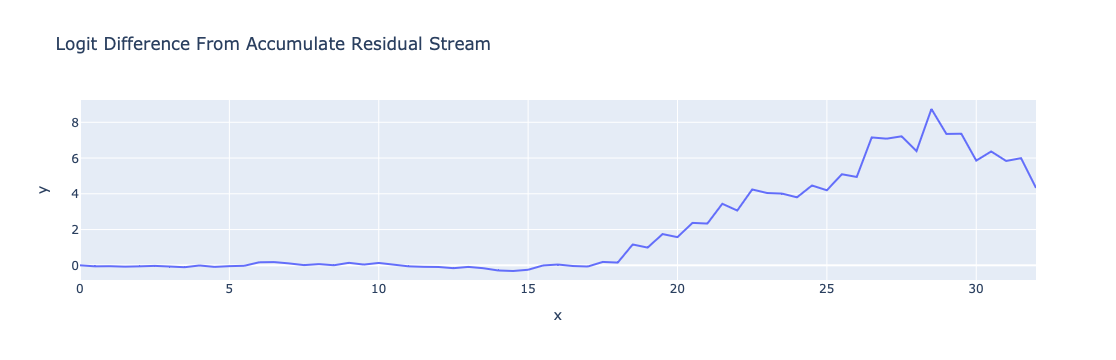

In [142]:
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True
)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache)
line(
    logit_lens_logit_diffs,
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    hover_name=labels,
    title="Logit Difference From Accumulate Residual Stream",
)

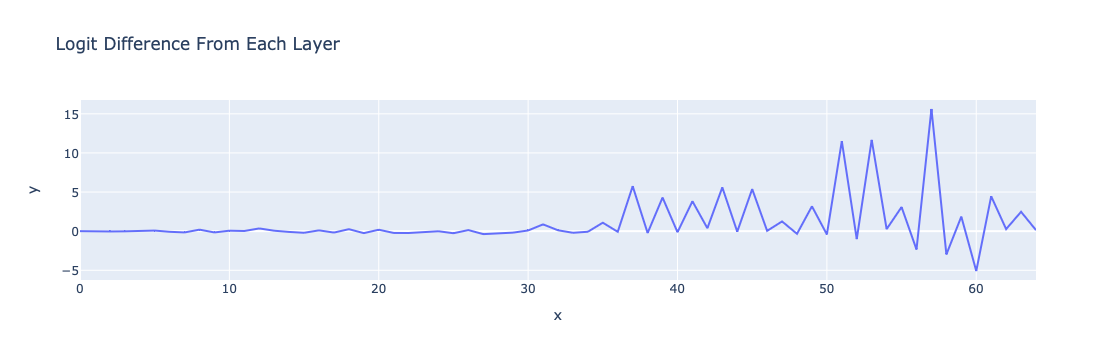

In [146]:
per_layer_residual, labels = cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

# Look into heads level analysis

In [174]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 700,
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    # Convert the tokens to strings (for the axis labels)
    str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    display(attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ))

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    #return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

In [158]:
per_head_residual.shape

torch.Size([1024, 4, 4096])

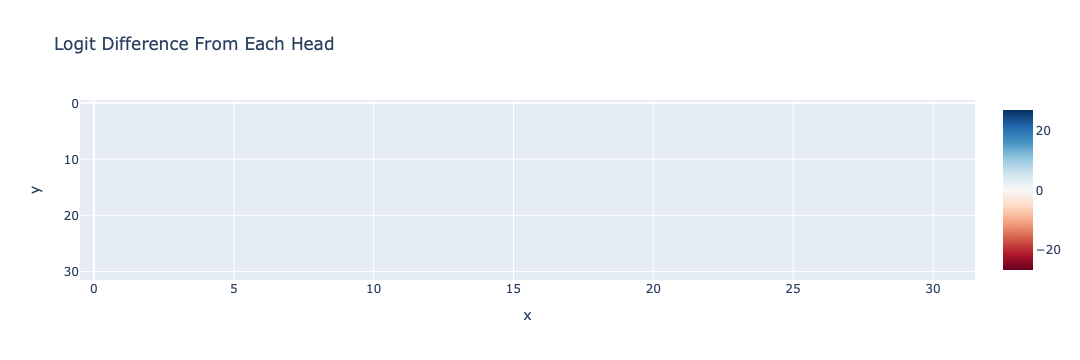

In [168]:
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
)

In [177]:
from circuitsvis.attention import attention_heads
from IPython.display import HTML, IFrame


top_k = 3

top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    cache,
    tokens[2],
    f"Top {top_k} Positive Logit Attribution Heads",
)

top_negative_logit_attr_heads = torch.topk(
    -per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    cache,
    tokens[2],
    title=f"Top {top_k} Negative Logit Attribution Heads",
)



# Activation patching

In [178]:
corrupted_prompts = []
for i in range(0, len(prompts), 2):
    corrupted_prompts.append(prompts[i + 1])
    corrupted_prompts.append(prompts[i])
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(
    corrupted_tokens, return_type="logits"
)
corrupted_average_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print("Corrupted Average Logit Diff", round(corrupted_average_logit_diff.item(), 2))
print("Clean Average Logit Diff", round(original_average_logit_diff.item(), 2))

Corrupted Average Logit Diff -4.33
Clean Average Logit Diff 4.33


In [179]:
model.to_string(corrupted_tokens)

['<s> When Tom and James went to the park,Tom gave the ball to ',
 '<s> When Tom and James went to the park,James gave the ball to ',
 '<s> After Martin and Max went to the park,Martin gave a drink to ',
 '<s> After Martin and Max went to the park,Max gave a drink to ']

In [181]:
from functools import partial

def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component


def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff) / (
        original_average_logit_diff - corrupted_average_logit_diff
    )


patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
            patched_logit_diff
        )

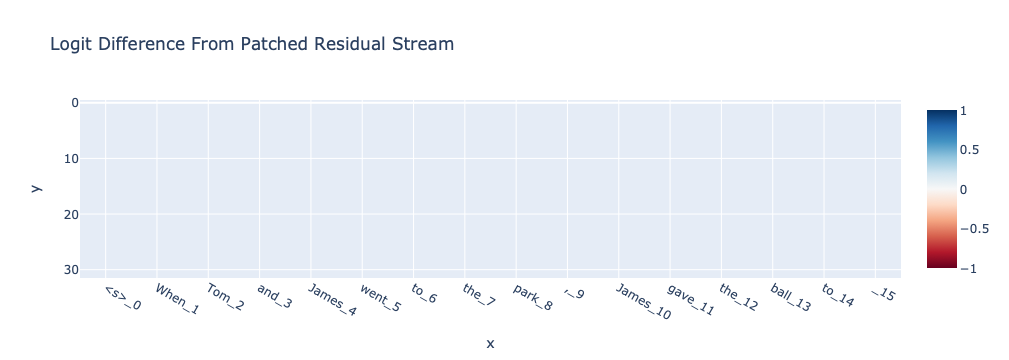

In [182]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(tokens[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

# Layer

In [183]:
patched_attn_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_attn_logit_diff = logits_to_ave_logit_diff(
            patched_attn_logits, answer_tokens
        )
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("mlp_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_mlp_logit_diff = logits_to_ave_logit_diff(
            patched_mlp_logits, answer_tokens
        )

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(
            patched_attn_logit_diff
        )
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(
            patched_mlp_logit_diff
        )

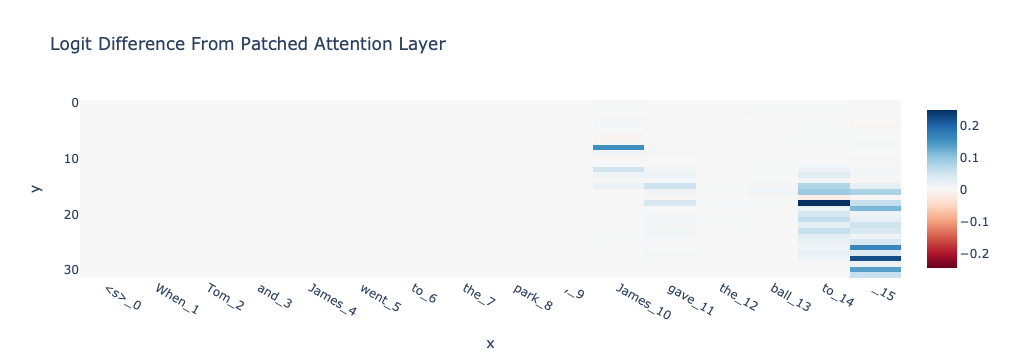

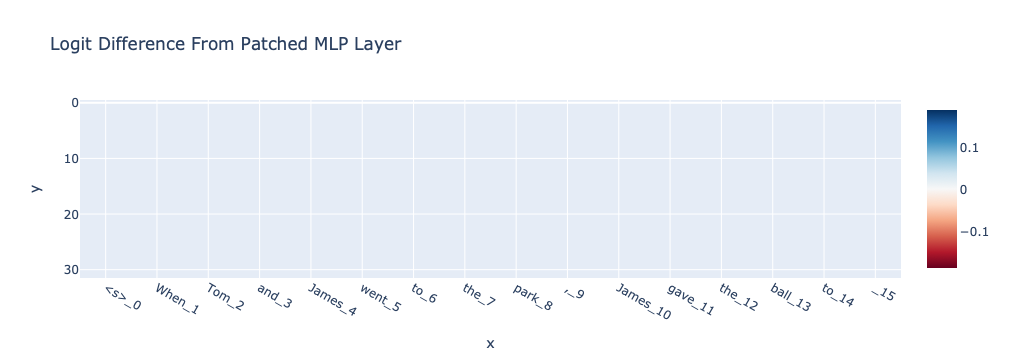

In [184]:
imshow(
    patched_attn_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Attention Layer",
    labels={"x": "Position", "y": "Layer"},
)
imshow(
    patched_mlp_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched MLP Layer",
    labels={"x": "Position", "y": "Layer"},
)

# Head

In [186]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("z", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

In [204]:
cache[(utils.get_act_name("z", layer, "attn"))].shape

torch.Size([4, 16, 32, 128])

In [187]:
patched_head_v_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("v", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_v_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

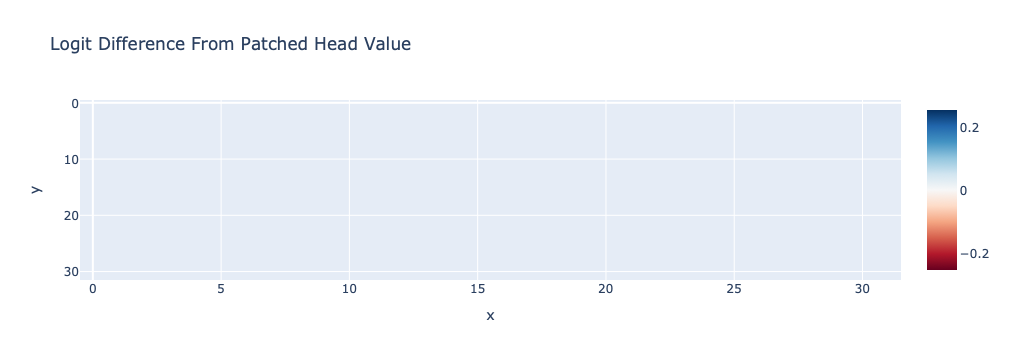

In [188]:
imshow(
    patched_head_v_diff,
    title="Logit Difference From Patched Head Value",
    labels={"x": "Head", "y": "Layer"},
)

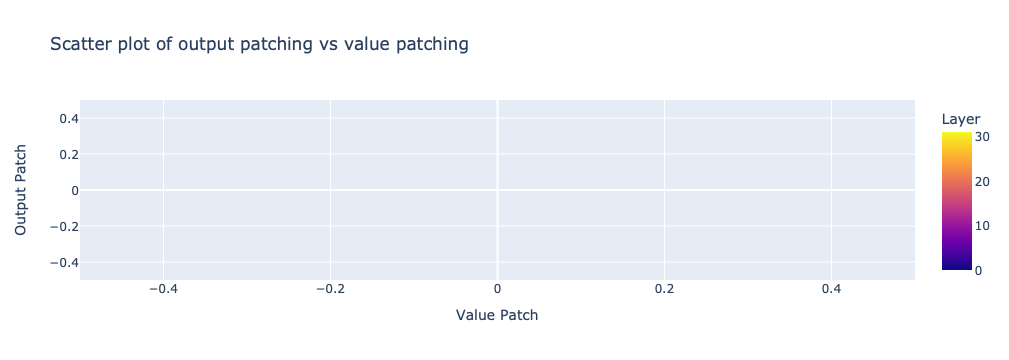

In [193]:
import plotly.express as px

def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()
    
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

In [207]:
def patch_head_pattern(
    corrupted_head_pattern: Float[torch.Tensor, "batch head_index query_pos d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_pattern[:, head_index, :, :] = clean_cache[hook.name][
        :, head_index, :, :
    ]
    return corrupted_head_pattern


patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_attn_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

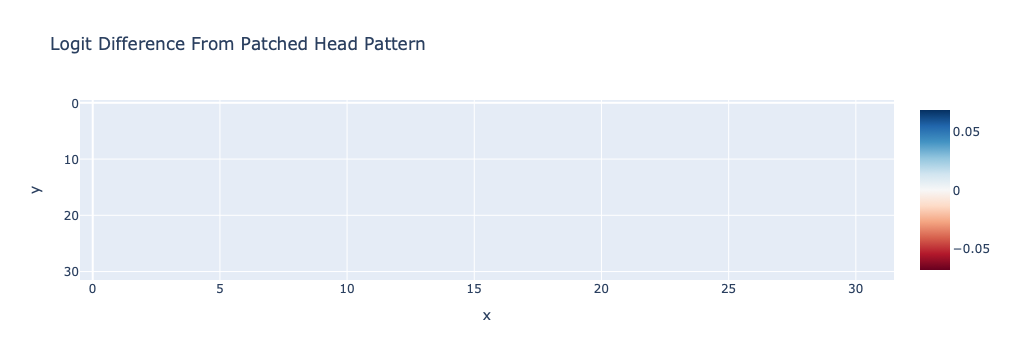

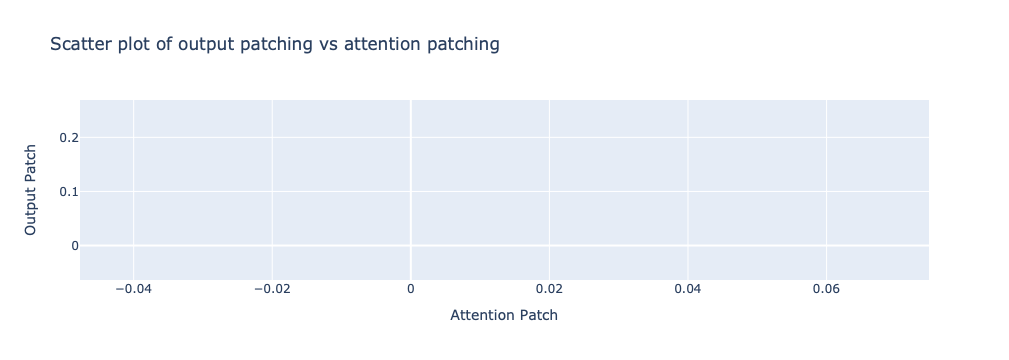

In [208]:
imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Pattern",
    labels={"x": "Head", "y": "Layer"},
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)

In [212]:
early_heads

tensor([], device='cuda:0', dtype=torch.int64)

In [210]:
top_heads_by_output_patch

tensor([490, 903, 585, 635, 532, 846, 972, 606, 728, 400], device='cuda:0')

In [214]:
top_k = 10
top_heads_by_output_patch = torch.topk(
    patched_head_z_diff.abs().flatten(), k=top_k
).indices
first_mid_layer = 16
first_late_layer = 20
early_heads = top_heads_by_output_patch[
    top_heads_by_output_patch < model.cfg.n_heads * first_mid_layer
]
mid_heads = top_heads_by_output_patch[
    torch.logical_and(
        model.cfg.n_heads * first_mid_layer <= top_heads_by_output_patch,
        top_heads_by_output_patch < model.cfg.n_heads * first_late_layer,
    )
]
late_heads = top_heads_by_output_patch[
    model.cfg.n_heads * first_late_layer <= top_heads_by_output_patch
]

early = visualize_attention_patterns(
    early_heads, cache, tokens[0], title=f"Top Early Heads"
)
mid = visualize_attention_patterns(
    mid_heads, cache, tokens[0], title=f"Top Middle Heads"
)
late = visualize_attention_patterns(
    late_heads, cache, tokens[0], title=f"Top Late Heads"
)

